In [1]:
import pandas as pd  #for storing and manipulating data locally
import numpy as np # for math
import datetime as dt # for dealing with time variables in the data
import matplotlib.pyplot as plt # for visualising the data
import seaborn as sns # for visualising their data

def q2url(string, endpoint = 'https://data.cityofnewyork.us/resource/fhrw-4uyv.csv'):
    """
    This function changes a query as a string to a url that will communicate that query to the API.
    
    Removes white space and new lines from the string. 
    Use %20 to insert white space in queries.
    """
    url = endpoint + "?"+string
    url = url.replace(" ","").replace("\n","")
    return url

# Spike in Department of Homelessness Calls in Manhattan in 2016

As I was going through the NYC 311 data, one of the most striking trends that I came across was that there was a dramatic spike in the number of calls which were routed to the Department of Homeless Services (DHS), I would like to dig into this a little.

In [6]:
city_agency3 = pd.DataFrame({'city':[], 'agency':[], 'date_trunc_ym_created_date':[], 'COUNT_unique_key':[]})

for city in ("NEW%20YORK", "BRONX", "BROOKLYN", "STATEN%20ISLAND"):
    qq = """$select=city,agency,date_trunc_ym(created_date),COUNT(unique_key)
                &$where=agency='DHS'&city='{}'
                &$group=city,agency,date_trunc_ym(created_date)
                &$limit=10000""".format(city)

    city_agency3 = city_agency3.append(pd.read_csv(q2url(qq)))

city_agency3.date_trunc_ym_created_date = pd.to_datetime(city_agency3.date_trunc_ym_created_date)

/Users/djkelleher/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


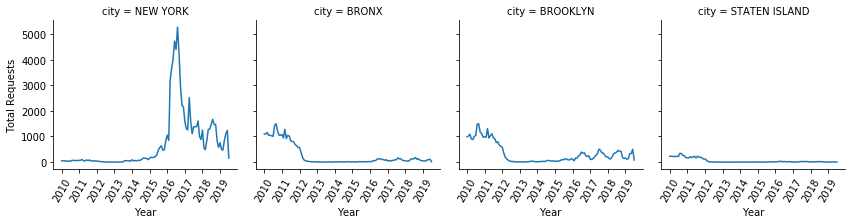

In [8]:
g = sns.FacetGrid(city_agency3, col = "city") 

g = g.map(sns.lineplot, "date_trunc_ym_created_date", "COUNT_unique_key" )

g = g.set_ylabels("Total Requests")
g = g.set_xlabels("Year")
g = g.set_xticklabels(labels = ["2009","2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"], rotation = 60)

## Calling the data

I am going to call data which has the location as an address, longitude, latitude, and the total calls in Manhattan that were routed to the DHS.

In [9]:
dhs_q = """$select= incident_address,COUNT(unique_key)%20AS%20total_calls,date_extract_y(created_date)%20as%20year,longitude,latitude
                    &$where=agency='DHS'&city='NEW%20YORK'
                    &$group=incident_address,year,longitude,latitude
                    &$limit=50 000"""
dhs_prime = pd.read_csv(q2url(dhs_q))
dhs_prime.shape

(33845, 5)

To clean up this data we shall put select only years which are complete. It seems like location was not recorded until 2013, so we only include 2013-2018.

I will also make two dataframes which have the null and not null addresses.

In [10]:
#
# Some Cleaning to only include complete years
dhs = dhs_prime[dhs_prime.year.isin([2013,2014,2015,2016,2017,2018])]
#
# Break into null and not null addresses
dhs_null = dhs[dhs.incident_address.isnull()]
dhs_notnull = dhs[~dhs.incident_address.isnull()]

## Number of unique callers

Of note in the BuzzFeed article, is that many of the calls were coming from one particular person, so the first thing I think we should do is to see compare the number of unique callers. We will also look at the number of unique locations to call from, because
$$
\text{Unique Callers}
\times
\text{Average Calls}
= 
\text{Total Calls}
$$

      total_calls  longitude   latitude
year                                   
2013     1.274419 -73.983131  40.751011
2014     1.148893 -73.978723  40.759418
2015     1.573534 -73.980455  40.755958
2016     2.933338 -73.979809  40.758820
2017     2.305876 -73.980049  40.758187
2018     2.140813 -73.980071  40.757992


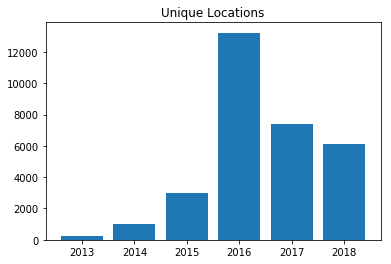

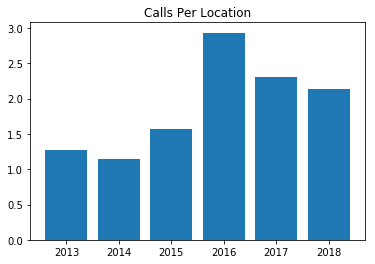

In [11]:
dhs_count = dhs.groupby('year').count()
dhs_mean = dhs.groupby('year').mean()

print(dhs_mean)
plt.bar(dhs_count.index, height = dhs_count.total_calls)
plt.title("Unique Locations")
plt.show()
plt.bar(dhs_mean.index, height = dhs_mean.total_calls)
plt.title("Calls Per Location")
plt.show()

Although we are seeing something like an 80\% increase in the average number of calls, we are seeing a much more dramatic increase in the number of unique locations which give the calls. 

The histograms are not super useful because the vast majority of location only have 1 call associated with them. This is important to note, because it suggests that the average has gone up because there are a few locations which have made a disproprtionate number of calls.

Let's take a look....

In [12]:
dhs.sort_values("total_calls").tail(10)

,incident_address,total_calls,year,longitude,latitude
3528,5 TIMES SQUARE,114,2018,-73.987208,40.755709
18588,1928 BROADWAY,115,2016,-73.982176,40.772503
31234,294 10 AVENUE,117,2016,-74.002256,40.750297
26151,530 5 AVENUE,121,2016,-73.979877,40.754879
28946,11 WEST 60 STREET,122,2016,-73.982675,40.769163
22991,81 EAST 125 STREET,141,2016,-73.939742,40.805365
5136,200 BROADWAY,187,2018,-74.009353,40.710533
21410,2018 BROADWAY,199,2018,-73.982131,40.776176
24732,NaN,215,2017,-73.987551,40.755780
20037,1841 BROADWAY,373,2016,-73.982429,40.769157


This hypothese is somewhat borne out just by looking at the ten biggest locations... although they are different than eachother for 2016, 2017, and 2016, and the max distance between two of them is about half a mile (800m).

I am going to make an improvised heat map of the number of calls using Seaborn below. 

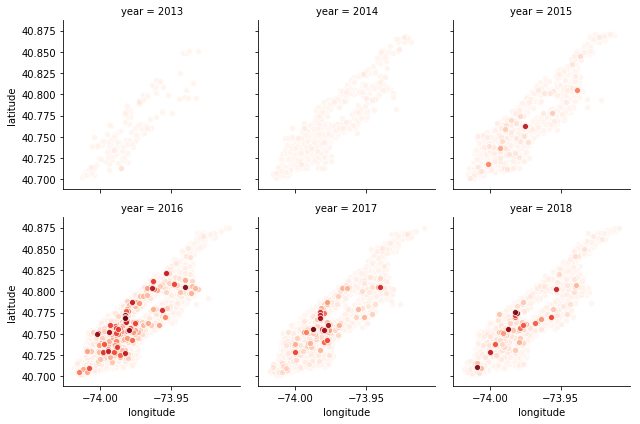

In [18]:
#sort and clean data.
dhs_sorted = dhs[dhs.year<2019].sort_values("total_calls")
#dhs_sorted.total_calls = dhs_sorted.total_calls.astype(float)
g = sns.FacetGrid(dhs_sorted, hue = "total_calls",
                 col = "year", col_wrap=3, palette = 'Reds') 


g = g.map(sns.scatterplot,
                 "longitude", 
                 "latitude",  alpha = 0.9)

g = g.set_ylabels("latitude")
g = g.set_xlabels("longitude")

## Conclusions

I'm not actually sure what to conclude from this, it seems that downtown is where the spike is centered. But that is not too surprising. 